<a href="https://colab.research.google.com/github/vandalt/phy3051-students-private/blob/main/tp11-transformers/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformeurs visuels (ViT) avec PyTorch

Dans ce cahier, nous allons compléter l'exemple commencé en classe au dernier cours.
Le but est d'apprendre à importer un modèle pré-défini et pré-entraîné dans PyTorch pour l'utiliser sur de nouvelles données.

In [26]:
import torch
import torchvision

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Importation du modèle

Le module `torchvision` de PyTorch implémente différent modèles pré-entraînés, incluant des [ViT](https://pytorch.org/vision/main/models/vision_transformer.html).
On peut directement importer le plus petit des modèles disponibles avec `vit_b_16`.
Cette fonction permet de créer un modèle complet lorsqu'elle est appelée.
On peut spécifier `weights="DEFAULT"` pour utiliser des poids pré-entraînés.
Tel que mentionné dans [la documentation](https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights), ces poids sont entraînés sur les données ImageNet-1K.
On peut aussi utiliser l'interface `ViT_B_16_Weights`, qui est intéressante car elle donne accès à une `transform` PyTorch pour convertir les données au format attendu (voir plus bas lors de la création de l'ensemble de données).

In [27]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [28]:
pretrained_weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=pretrained_weights).to(device)

In [29]:
parameters = list(model.parameters())
parameters[0].device

device(type='cuda', index=0)

Commençons par compter les paramètres du modèle

In [30]:
print("Number of parameters", sum(p.numel() for p in model.parameters()))

Number of parameters 86567656


On peut aussi visualiser l'architecture du modèle

In [31]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

On retrouve bien les éléments que nous avons vu dans le cours:

- 12 blocs d'encodeurs
- Une attention multi-tête
- Un bloc pleinement connecté
- Une normalisation de couche (`LayerNorm`)
- Une « tête » de classification à la fin du modèle

Pour comprendre comment les couches sont sont implémentées, on peut se référer directement au [code source](https://pytorch.org/vision/main/_modules/torchvision/models/vision_transformer.html#vit_b_16).

Remarquez que comme les données ImageNet ont 1000 classes, il y a 1000 sorties. On peut d'ailleurs accéder aux classes via les poids:

In [32]:
labels1k = pretrained_weights.meta["categories"]

## Importation des données

Comme dans les exemples vus plus tôt cette session, les données doivent être formattées dans un `Dataset` PyTorch.
Malheureusement, les données ImageNet utilisées pour entraîner le réseau sont très volumineuses.
Pour sauver du temps ici, nous utiliserons un ensemble de données déjà disponible dans PyTorch, soit l'ensemble [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

Comme le ViT s'attend à des images de 224x224 pixels, on convertit les images vers cette taille.
On pourrait le faire avec `torchvision.transforms` directement, mais les poids pré-entraînés donnent accès aux transformations permettant de rendre les données compatibles avec le modèle, soit:

- Une interpolation pour ajuster la taille des images 256x256
- Une découpure centrale de 224x224
- Une mise à l'échelle entre 0 et 1
- Un normalisation avec `mean=[0.485, 0.456, 0.406]` et `std=[0.229, 0.224, 0.225]`.

J'ai inclus une implémentation manuelle, mais on peut utiliser les poids directement pour éviter les erreurs.

In [33]:
from torchvision.transforms import Normalize, ToTensor, Compose, Resize, CenterCrop

transform_type = "weights"

if transform_type == "manual":
    transforms = Compose([
        Resize((256, 256)),
        CenterCrop((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
else:
    transforms = pretrained_weights.transforms()
train_dataset = torchvision.datasets.CIFAR10('../cifar10',  download=True, train=True, transform=transforms)
test_dataset = torchvision.datasets.CIFAR10('../cifar10',  download=True, train=False, transform=transforms)

In [34]:
train_dataset[0][0].device

device(type='cpu')

In [35]:
print("Classes de CIFAR10:", train_dataset.class_to_idx)
labels = list(train_dataset.class_to_idx)
label2idx = train_dataset.class_to_idx
idx2label = dict(zip(label2idx.values(), label2idx.keys()))

Classes de CIFAR10: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [36]:
print("Nombre d'images d'entraînement:", len(train_dataset))
print("Nombre d'images de test:", len(test_dataset))

Nombre d'images d'entraînement: 50000
Nombre d'images de test: 10000


In [37]:
from torch.utils.data import random_split
train_dataset = random_split(train_dataset, [0.1, 0.9])[0]
test_dataset = random_split(test_dataset, [0.1, 0.9])[0]

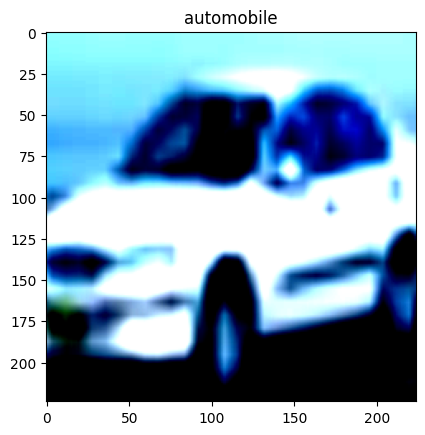

In [38]:
idx = torch.randint(len(train_dataset), ())
img, label = train_dataset[idx]
plt.imshow(img.permute(1, 2, 0))
plt.title(idx2label[label])
plt.show()

Remarquez les couleurs étranges. C'est dû aux transformations effectuées ci-dessus. Vous pouvez tester la version manuelle et enlever la normalisation pour le confirmer.

## Test du modèle

Comme le modèle est pré-entraîné, on peut s'attendre à une certaine qualité dans les prédictions.
Cependant, nos données ne sont pas les mêmes que celles utilisées à l'entraînement.
Le nom des classes n'est donc pas identique, et il se peut que des classes de CIFAR10 ne se trouvent pas dans ImageNet.
On peut tout de même extraire les classes ImageNet ayant la meilleure probabilité et les comparer avec la vraie classe de l'objet.

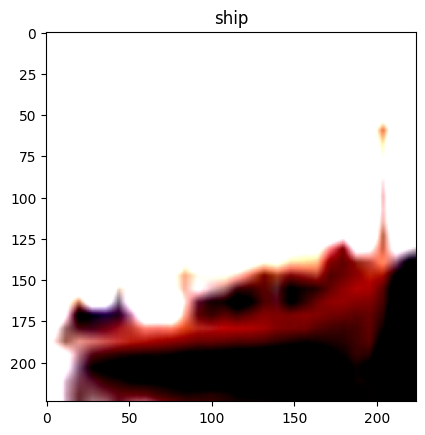

True CIFAR10 label: ship
Best image1k labels:
{'hourglass': 0.06576181948184967,
 'pirate': 0.6434047222137451,
 'schooner': 0.013492980040609837,
 'wreck': 0.004978801589459181,
 'yawl': 0.11143865436315536}


In [39]:
import torch.nn.functional as F
import pprint

idx = torch.randint(len(train_dataset), ())
img, label_idx = train_dataset[idx]
label = idx2label[label_idx]
pred1k = model(img.unsqueeze(0).to(device))

plt.imshow(img.permute(1, 2, 0))
plt.title(label)
plt.show()

prob1k = F.softmax(pred1k, dim=1)
n_best = 5
idx_best = torch.argsort(prob1k, dim=-1, descending=True)[:, :n_best].squeeze()
labels_best = [labels1k[idx] for idx in idx_best]
n_best_dict = dict(zip(labels_best, prob1k[:, idx_best].squeeze().tolist()))
print("True CIFAR10 label:", label)
print("Best image1k labels:")
pprint.pprint(n_best_dict)

En répétant la cellule ci-dessus quelques fois, on voit que la prédiction n'est pas si mauvaise dans plusieurs cas.

## Entraînement

Dans l'espoir d'améliorer la performance modèle, on peut effectuer un entraînement spécifiquement pour les données CIFAR10.
Comme le modèle est pré-entraîné, on nomme souvent cet entraînement _fine tuning_.
Pour ce faire il faudra:

- Remplacer la tête de classification pour qu'elle ait 10 catégories de sortie.
- Choisir quels paramètres entraîner. On pourra « geler » le ViT et seulement entraîner le classificateur, ou bien entraîner tout le modèle.
- Définir une boucle d'entraînement comme nous l'avons fait dans les TPs précédents.

### Remplacement du classificateur

Pour remplacer le classificateur, voyons voir comment ce dernier est implémenté dans le modèle initial:

In [40]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

On voit que la tête de classification (`heads`) est définie avec `nn.Linear`. On peut y accéder comme suit:

In [41]:
model.heads.head

Linear(in_features=768, out_features=1000, bias=True)

Pour obtenir 10 classes au lieu de 1000, il suffit de réassigner cet élément avec une nouvelle couche linéaire:

In [42]:
from torch import nn

model.heads.head = nn.Linear(768, out_features=10, device=device)

Vérifions que le changement s'est bien fait:

In [43]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

et que le modèle prédit en effet 10 classes:

In [44]:
out = model(img.unsqueeze(0).to(device))
out

tensor([[ 0.0657, -0.2221,  0.0425, -0.2115,  0.2137, -0.3882,  0.1810, -0.3867,
          0.9179,  0.1941]], device='cuda:0', grad_fn=<AddmmBackward0>)

Cependant, comme cette nouvelle couche n'est pas entraînée, les prédictions ne seront pas bonnes.
C'est pourquoi il faut ajuster le modèle.

### Boucle d'entraînement

La boucle d'entraînement fonctionne comme dans les TPs précéðent

In [45]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [46]:
def train_loop(dataloader, model, loss_fn, optimizer):

    # Taille de l'ensemble d'entraînement
    size = len(dataloader.dataset)

    # Itération sur les batches (dataloader nous donne les données par batch)
    # X est l'image et y la classe
    train_loss = 0.0
    for batch, (X, y) in enumerate(dataloader):
        # Fonction objectif
        X = X.to(device)
        y = y.to(device)
        pred = model(X)  # prédiction
        loss = loss_fn(pred, y)

        # Rétropropagation
        optimizer.zero_grad()  # On réinitialise le gradient d'abord
        loss.backward()  # Rétropropagation
        optimizer.step()  # On fait un pas dans l'espace paramètre

        loss, current = loss.item(), (batch+1) * len(X)
        train_loss += loss * X.size(0)
        # Progrès
        if batch % 100 == 0:
            print(f"Loss: {loss}, [{current}/{size}]")

    return train_loss / size

In [47]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = correct = 0

    # On se sauve les gradients comme ils ne sont pas utilisés
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()  # Compute loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss} \n")

    return test_loss

Préparons maintenant les données avec les classes `DataLoader`.

In [48]:
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                        shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

Commençons par évaluer le modèle initial sur les données test, pour voir la performance sans aucun ajustement.

In [49]:
model.eval()
test_loss = test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 13.3%, Avg loss: 2.292929566095746 



In [ ]:
epochs = 10
train_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train()
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    model.eval()
    test_loss = test_loop(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 2.2584729194641113, [16/5000]
Loss: 1.5879453420639038, [1616/5000]
Loss: 1.0549874305725098, [3216/5000]
